In [1]:
import os
import re
import pickle
import numpy as np
import torch
from collections import defaultdict

In [2]:

def update_running_mean(running_mean, count, new_sample):
    """
    One‐step Welford update for the mean.
    running_mean : np.ndarray  (same shape as new_sample)
    count        : int         (number of samples seen so far)
    new_sample   : np.ndarray  (the incoming sample)
    Returns: (updated_mean, updated_count)
    """
    count += 1
    # Δ = x - μ_prev
    delta = new_sample - running_mean
    # μ_new = μ_prev + Δ / count
    running_mean += delta / count
    return running_mean, count

# ──────────────────────────────────────────────────────────────────────────────
# 1) Configuration: adjust these to your setup
# ──────────────────────────────────────────────────────────────────────────────
base_dir = "/n/home13/xupan/sompolinsky_lab/object_relation/latents"      # contains subfolders seed1, seed2, …

# success_map maps each prompt_id → { seed_int: bool_is_success, … }
# e.g.: success_map = { 632: {1:True, 2:False, 3:True, 4:False, 5:True}, … }

# Load success/failure map from binary_mask.pkl
with open("binary_mask.pkl", "rb") as f:
    success_map = pickle.load(f)


# ──────────────────────────────────────────────────────────────────────────────
# 2) Prepare storage for running means & counts
# ──────────────────────────────────────────────────────────────────────────────
mean_succ = None
count_succ = 0
mean_fail = None
count_fail = 0

# ──────────────────────────────────────────────────────────────────────────────
# 3) Iterate seed folders & update per-prompt stats
# ──────────────────────────────────────────────────────────────────────────────
seed_dirs = sorted(d for d in os.listdir(base_dir) if d.startswith("seed"))
pattern = re.compile(r"spatial_img_latent_residual_allblocks_prompt_(\d+)_seed_(\d+)\.pkl")

for seed_dir in seed_dirs:
    seed_num = int(seed_dir.replace("seed", ""))
    folder = os.path.join(base_dir, seed_dir)
    for fname in os.listdir(folder)[0:1]:
        m = pattern.match(fname)
        if not m:
            continue

        prompt_id = int(m.group(1))
        # load the latent for this prompt & seed
        path = os.path.join(folder, fname)
        # 1) Skip truly empty files
        if os.path.getsize(path) == 0:
            print(f"Skipping empty file: {path}")
            continue  # :contentReference[oaicite:0]{index=0}

        # 2) Try to unpickle safely
        try:
            with open(path, "rb") as f:
                latent = pickle.load(f)
                break
        except EOFError:
            print(f"Skipping corrupted/truncated file: {path}")
            continue  # :contentReference[oaicite:1]{index=1}
        latent_array = latent['block_0_residual_spatial_state_traj'][:,1,:,:,:].to(torch.float32).numpy()
        latent = latent_array
        # success_map is a dict mapping prompt_id to list of successful seeds
        is_success = prompt_id in success_map and seed_num in success_map[prompt_id]

        # pick which global mean to update
        if is_success:
            if mean_succ is None:
                # first time: initialize to zeros of same shape
                mean_succ = np.zeros_like(latent)
            mean_succ, count_succ = update_running_mean(mean_succ, count_succ, latent)
        else:
            if mean_fail is None:
                mean_fail = np.zeros_like(latent)
            mean_fail, count_fail = update_running_mean(mean_fail, count_fail, latent)

# ──────────────────────────────────────────────────────────────────────────────
# AFTER LOOP: mean_succ and mean_fail hold the global averages
# count_succ and count_fail tell you how many samples went into each
# ──────────────────────────────────────────────────────────────────────────────
print(f"Succeeded seeds aggregated: {count_succ}")
print(f"Failed    seeds aggregated: {count_fail}")
# Now mean_succ and mean_fail are your two (14×1×32×32×1152) arrays

Succeeded seeds aggregated: 0
Failed    seeds aggregated: 0


In [3]:
latent.keys()

dict_keys(['prompt', 'random_seed', 'image_logs', 'latents_traj', 'pred_traj', 't_traj', 'block_0_residual_spatial_state_traj', 'block_1_residual_spatial_state_traj', 'block_2_residual_spatial_state_traj', 'block_3_residual_spatial_state_traj', 'block_4_residual_spatial_state_traj', 'block_5_residual_spatial_state_traj', 'block_6_residual_spatial_state_traj', 'block_7_residual_spatial_state_traj', 'block_8_residual_spatial_state_traj', 'block_9_residual_spatial_state_traj', 'block_10_residual_spatial_state_traj', 'block_11_residual_spatial_state_traj', 'block_12_residual_spatial_state_traj', 'block_13_residual_spatial_state_traj', 'block_14_residual_spatial_state_traj', 'block_15_residual_spatial_state_traj', 'block_16_residual_spatial_state_traj', 'block_17_residual_spatial_state_traj', 'block_18_residual_spatial_state_traj', 'block_19_residual_spatial_state_traj', 'block_20_residual_spatial_state_traj', 'block_21_residual_spatial_state_traj', 'block_22_residual_spatial_state_traj', '

In [18]:
# Save mean_succ to pickle file
with open('mean_latents/mean_succ_block_0.pkl', 'wb') as f:
    pickle.dump(mean_succ, f)

# Save mean_succ to pickle file
with open('mean_latents/mean_fail_block_0.pkl', 'wb') as f:
    pickle.dump(mean_fail, f)


In [5]:
# Load mean_succ from pickle file
with open('mean_latents/mean_succ_block_0.pkl', 'rb') as f:
    mean_succ = pickle.load(f)

# Load mean_fail from pickle file 
with open('mean_latents/mean_fail_block_0.pkl', 'rb') as f:
    mean_fail = pickle.load(f)

#### Global divergence curve

In [19]:
# mean_succ, mean_fail: np.ndarray, each shape (T, H, W, D)
T, H, W, D = mean_succ.shape

divergences = np.linalg.norm((mean_succ - mean_fail).reshape(T, -1), axis=1)


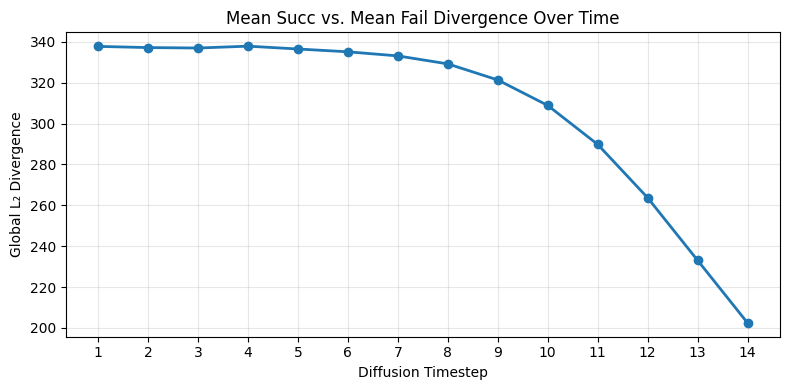

In [20]:
import matplotlib.pyplot as plt

timesteps = np.arange(1, T+1)

plt.figure(figsize=(8, 4))
plt.plot(timesteps, divergences, marker='o', linewidth=2)
plt.xlabel("Diffusion Timestep")
plt.ylabel("Global L₂ Divergence")
plt.title("Mean Succ vs. Mean Fail Divergence Over Time")
plt.xticks(timesteps)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### Patch-wise heatmap

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_patch_heatmaps(mean_succ, mean_fail, save_dir):
    """
    Generate and save per-timestep patch-wise heatmaps of L2 differences.
    mean_succ, mean_fail: np.ndarray of shape (T, H, W, D)
    save_dir: directory to save PNGs
    """
    os.makedirs(save_dir, exist_ok=True)
    T, H, W, D = mean_succ.shape

    for t in range(T):
        # compute per-patch L2 differences
        diffs = mean_succ[t] - mean_fail[t]               # shape (H, W, D)
        heatmap = np.linalg.norm(diffs.reshape(H, W, D), axis=2)

        # plot heatmap
        plt.figure(figsize=(4, 4))
        plt.imshow(heatmap, cmap='hot', interpolation='nearest')
        plt.colorbar()
        plt.title(f"Timestep {t+1}")
        plt.xticks([]); plt.yticks([])
        # save figure
        plt.savefig(os.path.join(save_dir, f"heatmap_t{t+1:02d}.png"))
        plt.close()

# Usage example:
plot_patch_heatmaps(mean_succ, mean_fail, save_dir="patch_heatmaps")


#### Dimensionality Reduction & Clustering

In [7]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_over_time(mean_succ, mean_fail, n_components=2):
    """
    Perform PCA on concatenated means at each timestep and plot trajectories.
    mean_succ, mean_fail: arrays of shape (T, H, W, D)
    """
    T, H, W, D = mean_succ.shape
    # reshape to (T, D_total)
    data = np.vstack([
        mean_succ.reshape(T, -1),
        mean_fail.reshape(T, -1)
    ])  # shape (2T, H*W*D)

    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(data)  # → (2T, n_components)

    # split back
    succ_proj = proj[:T]
    fail_proj = proj[T:]

    # plot
    plt.figure(figsize=(6, 6))
    plt.plot(succ_proj[:,0], succ_proj[:,1], 'o-', label='succ')  # :contentReference[oaicite:4]{index=4}
    plt.plot(fail_proj[:,0], fail_proj[:,1], 's--', label='fail')
    for t in range(T):
        plt.text(succ_proj[t,0], succ_proj[t,1], str(t+1))
        plt.text(fail_proj[t,0], fail_proj[t,1], str(t+1))
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.title('PCA Projection of Mean Latents Over Time')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


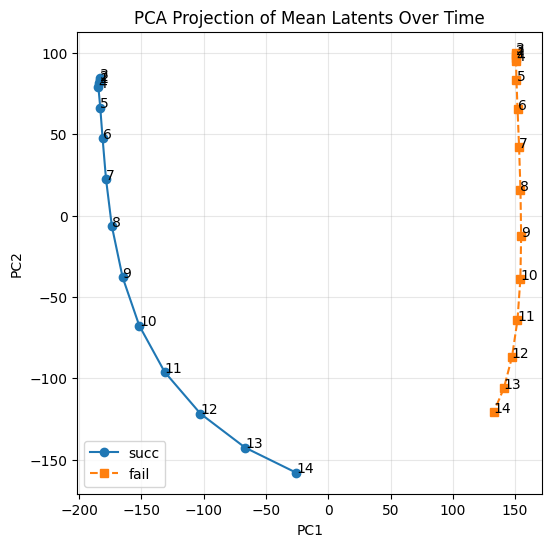

In [8]:
pca_over_time(mean_succ, mean_fail)

#### CKA

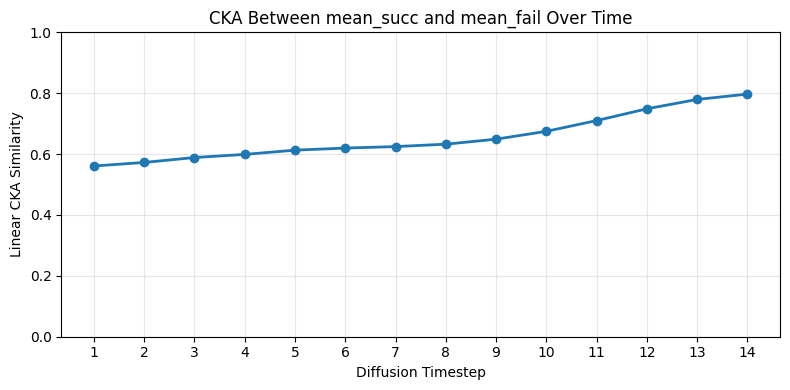

In [12]:
import numpy as np

def center_gram(K: np.ndarray) -> np.ndarray:
    """
    Center a Gram matrix K using H = I - 1/n 11^T.
    Args:
      K: (n, n) Gram matrix (e.g., X @ X.T)
    Returns:
      K_c: centered Gram matrix
    """
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    # H K H = K - 1/n 1K - 1/n K1 + 1/n^2 11K11
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

def hsic(K_c: np.ndarray, L_c: np.ndarray) -> float:
    """
    Compute unnormalized HSIC between two centered Gram matrices.
    """
    return np.trace(K_c @ L_c) / ((K_c.shape[0] - 1)**2)


def linear_CKA(X: np.ndarray, Y: np.ndarray) -> float:
    """
    Compute linear CKA similarity between two representation matrices.
    Args:
      X: (n, d1) matrix of representations
      Y: (n, d2) matrix of representations
    Returns:
      cka: scalar similarity in [0,1]
    """
    # Gram matrices
    K = X @ X.T       # shape (n, n)
    L = Y @ Y.T       # shape (n, n)
    # Centered Gram matrices
    K_c = center_gram(K)
    L_c = center_gram(L)
    # Compute HSIC scores
    hsic_KL = hsic(K_c, L_c)
    hsic_KK = hsic(K_c, K_c)
    hsic_LL = hsic(L_c, L_c)
    # Normalized CKA
    return hsic_KL / np.sqrt(hsic_KK * hsic_LL)


# mean_succ, mean_fail: np.ndarray of shape (T, H, W, D)
T, H, W, D = mean_succ.shape
cka_scores = []
for t in range(T):
    # reshape to (n_patches, D)
    X = mean_succ[t].reshape(H * W, D)
    Y = mean_fail[t].reshape(H * W, D)
    score = linear_CKA(X, Y)
    cka_scores.append(score)
cka_scores = np.array(cka_scores)  # shape (T,)

timesteps = np.arange(1, T+1)

plt.figure(figsize=(8, 4))
plt.plot(timesteps, cka_scores, marker='o', linewidth=2)
plt.xlabel("Diffusion Timestep")
plt.ylabel("Linear CKA Similarity")
plt.title("CKA Between mean_succ and mean_fail Over Time")
plt.xticks(timesteps)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### SVD over time

In [13]:
import numpy as np

def spectral_evolution(mean_latents, top_k=10):
    """
    Compute the top_k singular values of the covariance of mean_latents
    at each timestep.
    
    Args:
      mean_latents: np.ndarray of shape (T, H, W, D)
      top_k:        int, number of singular values to track
    Returns:
      sv_track: np.ndarray of shape (T, top_k)
    """
    T, H, W, D = mean_latents.shape
    n_patches = H * W
    sv_track = np.zeros((T, top_k), dtype=np.float64)

    for t in range(T):
        # 1) Reshape to (n_patches, D)
        X = mean_latents[t].reshape(n_patches, D)
        
        # 2) Center features (optional if already zero-mean)
        X_centered = X - X.mean(axis=0, keepdims=True)  # rowvar=False :contentReference[oaicite:5]{index=5}

        # 3) Compute covariance matrix
        #    Use np.cov for clarity:
        cov = np.cov(X_centered, rowvar=False, ddof=0)  # shape (D, D) :contentReference[oaicite:6]{index=6}
        #    # Or equivalently:
        #    # cov = (X_centered.T @ X_centered) / (n_patches - 1)  # scatter matrix :contentReference[oaicite:7]{index=7}

        # 4) Singular Value Decomposition
        #    U @ np.diag(S) @ Vt = cov, S sorted descending :contentReference[oaicite:8]{index=8}
        U, S, Vt = np.linalg.svd(cov, full_matrices=False)  

        # 5) Clip any tiny negative values due to numerical error
        S = np.clip(S, a_min=0, a_max=None)  # ensure non-negative :contentReference[oaicite:9]{index=9}

        # 6) Store top_k singular values
        sv_track[t, :] = S[:top_k]

    return sv_track


In [14]:
import matplotlib.pyplot as plt

def plot_spectral_evolution(sv_track):
    """
    Plot the top-k singular values over timesteps.
    
    Args:
      sv_track: np.ndarray of shape (T, k)
    """
    T, k = sv_track.shape
    timesteps = np.arange(1, T+1)

    plt.figure(figsize=(8, 5))
    for i in range(k):
        plt.plot(timesteps, sv_track[:, i],
                 marker=('o' if i==0 else None),
                 linestyle=('-' if i==0 else '--'),
                 label=f"SV{i+1}")
    plt.xlabel("Diffusion Timestep")
    plt.ylabel("Singular Value")
    plt.title("Spectral Evolution of Latent Covariance")  
    plt.xticks(timesteps)
    plt.legend(title="Modes", ncol=2, fontsize='small')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


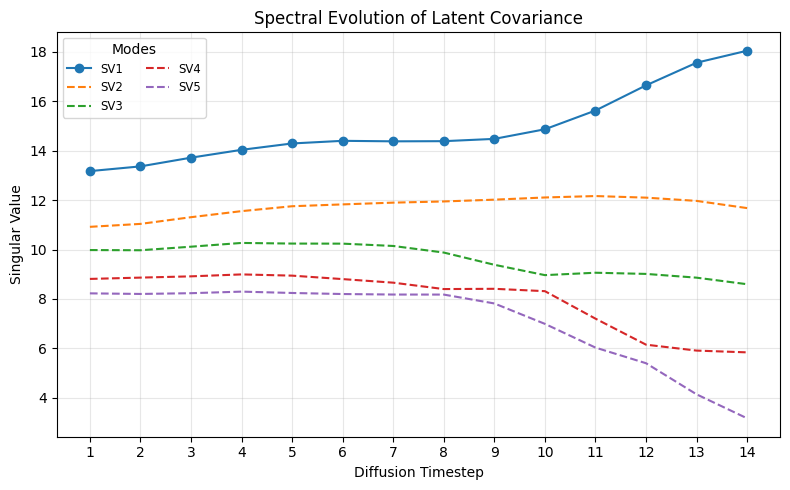

In [15]:
# Assume mean_succ is your (T, H, W, D) array
sv_track_succ = spectral_evolution(mean_succ, top_k=5)
plot_spectral_evolution(sv_track_succ)


#### Prep classifier

In [7]:

# Load success/failure map
with open("binary_mask.pkl", "rb") as f:
    success_map = pickle.load(f)
# Get all prompt IDs from success_map
valid_prompt_ids = set(success_map.keys())
# Initialize dictionaries to store arrays
succ_arrays = defaultdict(list)
fail_arrays = defaultdict(list)

# Iterate seed folders & collect arrays
seed_dirs = sorted(d for d in os.listdir("/n/home13/xupan/sompolinsky_lab/object_relation/latents") if d.startswith("seed"))
pattern = re.compile(r"spatial_img_latent_residual_allblocks_prompt_(\d+)_seed_(\d+)\.pkl")

for seed_dir in seed_dirs:
    seed_num = int(seed_dir.replace("seed", ""))
    folder = os.path.join("/n/home13/xupan/sompolinsky_lab/object_relation/latents", seed_dir)
    for fname in os.listdir(folder)[0:2]:
        m = pattern.match(fname)
        if not m:
            continue

        prompt_id = int(m.group(1))
        # Skip if prompt_id is not in success_map
        if prompt_id not in valid_prompt_ids:
            continue
        path = os.path.join(folder, fname)
        
        # Skip empty files
        if os.path.getsize(path) == 0:
            print(f"Skipping empty file: {path}")
            continue

        # Try to unpickle safely
        try:
            with open(path, "rb") as f:
                latent = pickle.load(f)
        except EOFError:
            print(f"Skipping corrupted/truncated file: {path}")
            continue

        # Get 4D array and average over middle dimensions
        latent_array = latent[f'block_0_residual_spatial_state_traj'][:,1,:,:,:].to(torch.float32).numpy()
        latent_2d = np.mean(latent_array, axis=(1, 2))  # Average over middle dimensions

        is_success = prompt_id in success_map and success_map[prompt_id][seed_num-1] == 1


        if is_success:
            succ_arrays[(prompt_id, seed_num)].append(latent_2d)
        else:
            fail_arrays[(prompt_id, seed_num)].append(latent_2d)

# Convert lists to numpy arrays for each prompt_id
#succ_arrays = {k: np.array(v) for k, v in succ_arrays.items()}
#fail_arrays = {k: np.array(v) for k, v in fail_arrays.items()}


In [30]:
# Load pre-saved arrays
with open("classifier_prep_latents/fail_arrays_block_4.pkl", "rb") as f:
    fail_arrays_4 = pickle.load(f)

with open("classifier_prep_latents/succ_arrays_block_4.pkl", "rb") as f:
    succ_arrays_4 = pickle.load(f)



#### Pipeline for preparing data for classification

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_dataset(dict_correct, dict_incorrect, time_step):
    """
    From two dicts of {(f1,f2): array[time,latent_dim]}, extract:
      X         — shape (n_samples, latent_dim)
      y         — shape (n_samples,) binary labels (1=correct,0=incorrect)
      factor1   — shape (n_samples,) the f1 for each sample
      factor2   — shape (n_samples,) the f2 for each sample
    """
    data, labels, f1_list, f2_list = [], [], [], []
    
    # correct=1
    for (f1, f2), arr in dict_correct.items():
        arr = arr.squeeze()
        #print(arr.shape)
        data.append(arr[time_step])
        labels.append(1)
        f1_list.append(f1)
        f2_list.append(f2)
    
    # incorrect=0
    for (f1, f2), arr in dict_incorrect.items():
        arr = arr.squeeze()
        data.append(arr[time_step])
        labels.append(0)
        f1_list.append(f1)
        f2_list.append(f2)
    #print(len(data),data[0].shape)
    X = np.vstack(data)                  # (n_samples, latent_dim)
    y = np.array(labels, dtype=int)      # (n_samples,)
    factor1 = np.array(f1_list)          # (n_samples,)
    factor2 = np.array(f2_list)          # (n_samples,)
    return X, y, factor1, factor2

# --- splitting functions --- #

def split_stratified_by(X, y, stratify_array, test_size=0.2, random_state=0):
    """
    Wrapper around train_test_split with stratification.
    stratify_array should be the same length as y.
    """
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_array
    )

def split_unstratified(X, y, test_size=0.2, random_state=0):
    """
    Simple random split, no stratification.
    """
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=None
    )



In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import glob
from collections import Counter

# find all of your “success” files
succ_paths = sorted(glob.glob("classifier_prep_latents/succ_arrays_block_*.pkl"))


results_test = {}
results_train = {}
for succ_path in succ_paths:
    # derive the corresponding failure path
    fail_path = succ_path.replace("succ_arrays", "fail_arrays")
    
    # extract a block identifier for labeling
    block_id = succ_path.rstrip(".pkl").split("_")[-1]
    
    # load the dicts
    with open(fail_path, "rb") as f:
        dict_incorrect = pickle.load(f)
    with open(succ_path, "rb") as f:
        dict_correct = pickle.load(f)
    # ————— Run through timesteps ————— #
    # initialize lists for each method
    res_test = {
        'logistic': [],
        'uniform': [],
        'most_frequent': [],
        'stratified': []
    }
    res_train = {
        'logistic': [],
        'uniform': [],
        'most_frequent': [],
        'stratified': []
    }  
    for t in range(14):
        X, y,f1,f2 = prepare_dataset(dict_correct, dict_incorrect, t)
        #X_train, X_test, y_train, y_test = split_stratified_by(X, y,stratify_array=f2)
        # STRATIFIED SPLIT BY factor2, *including* f2 so we get f2_train/test
        X_train, X_test, y_train, y_test, f2_train, f2_test = train_test_split(
            X, y, f2,
            test_size=0.2,
            random_state=0,
            stratify=f2
        )

        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        acc_test = clf.score(X_test, y_test)
        acc_train = clf.score(X_train, y_train)
        res_test['logistic'].append(acc_test)
        res_train['logistic'].append(acc_train)
        # — baselines
        dummies = {
            'uniform': DummyClassifier(strategy='uniform', random_state=0),
            'most_frequent': DummyClassifier(strategy='most_frequent'),
        }
        for name, dummy in dummies.items():
            dummy.fit(X_train, y_train)
            res_test[name].append(dummy.score(X_test, y_test))
            res_train[name].append(dummy.score(X_train, y_train))
        # — Factor-2 majority-rule baseline
        # Learn majority label per f2 from train
        maj_label = {
            val: Counter(y_train[f2_train == val]).most_common(1)[0][0]
            for val in np.unique(f2_train)
        }
        # Predict on test & train
        y_pred_test  = np.array([maj_label[val] for val in f2_test])
        y_pred_train = np.array([maj_label[val] for val in f2_train])
        res_test ['stratified'].append(np.mean(y_pred_test  == y_test))
        res_train['stratified'].append(np.mean(y_pred_train == y_train))
    results_test[block_id] = res_test
    results_train[block_id] = res_train



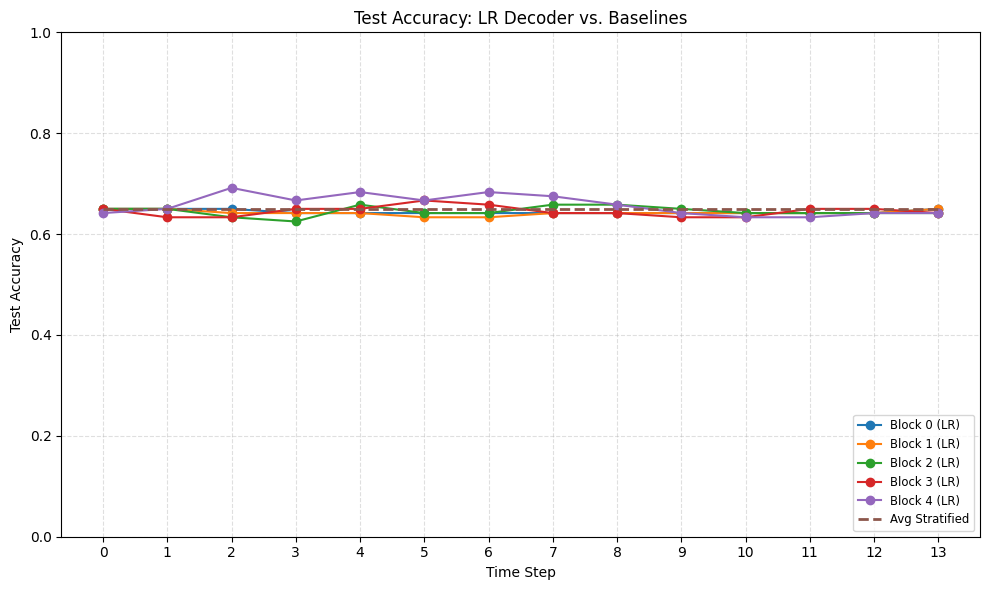

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# methods to average & plot as baselines
baseline_methods = ['stratified']

plt.figure(figsize=(10,6))

# 1) plot each block’s LogisticRegression curve
for block_id, res in results_test.items():
    plt.plot(
        range(14),
        res['logistic'],
        marker='o',
        label=f"Block {block_id} (LR)"
    )

# 2) compute & plot the mean baseline curve across blocks
for method in baseline_methods:
    # stack each block’s method‐curve into an array of shape (n_blocks, 14)
    all_curves = np.vstack([res[method] for res in results_test.values()])
    mean_curve = np.mean(all_curves, axis=0)
    plt.plot(
        range(14),
        mean_curve,
        linestyle='--',
        linewidth=2,
        label=f"Avg {method.replace('_',' ').title()}"
    )

plt.xlabel('Time Step')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: LR Decoder vs. Baselines')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


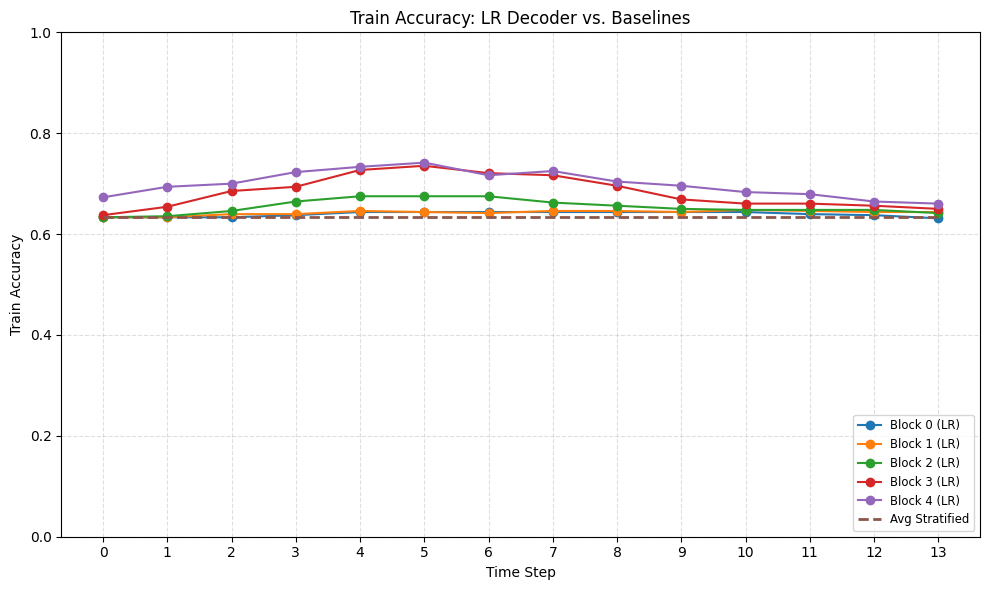

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# methods to average & plot as baselines
baseline_methods = ['stratified']

plt.figure(figsize=(10,6))

# 1) plot each block’s LogisticRegression curve
for block_id, res in results_train.items():
    plt.plot(
        range(14),
        res['logistic'],
        marker='o',
        label=f"Block {block_id} (LR)"
    )

# 2) compute & plot the mean baseline curve across blocks
for method in baseline_methods:
    # stack each block’s method‐curve into an array of shape (n_blocks, 14)
    all_curves = np.vstack([res[method] for res in results_train.values()])
    mean_curve = np.mean(all_curves, axis=0)
    plt.plot(
        range(14),
        mean_curve,
        linestyle='--',
        linewidth=2,
        label=f"Avg {method.replace('_',' ').title()}"
    )

plt.xlabel('Time Step')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy: LR Decoder vs. Baselines')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()


In [21]:
# 1) stratify by factor1
#X_train_f1, X_test_f1, y_train_f1, y_test_f1 = split_stratified_by(X, y, stratify_array=f1)

# 2) stratify by factor2
#X_train_f2, X_test_f2, y_train_f2, y_test_f2 = split_stratified_by(X, y, stratify_array=f2)

# 3) no stratification
#X_train, X_test, y_train, y_test = split_unstratified(X, y)



In [58]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import glob
# find all of your “success” files
succ_paths = sorted(glob.glob("classifier_prep_latents/succ_arrays_block_*.pkl"))

results_test = {}  # block_id -> list of 14 accuracies
results_train = {}  # block_id -> list of 14 accuracies

for succ_path in succ_paths:
    # derive the corresponding failure path
    fail_path = succ_path.replace("succ_arrays", "fail_arrays")
    
    # extract a block identifier for labeling
    block_id = succ_path.rstrip(".pkl").split("_")[-1]
    
    # load the dicts
    with open(fail_path, "rb") as f:
        dict_incorrect = pickle.load(f)
    with open(succ_path, "rb") as f:
        dict_correct = pickle.load(f)
    # ————— Run through timesteps ————— #
    accuracies_test = []
    accuracies_train = []
    for t in range(14):
        X, y,f1,f2 = prepare_dataset(dict_correct, dict_incorrect, t)
        X_train, X_test, y_train, y_test = split_stratified_by(X, y,stratify_array=f1)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        acc_test = clf.score(X_test, y_test)
        acc_train = clf.score(X_train, y_train)
        accuracies_test.append(acc_test)
        accuracies_train.append(acc_train)
    results_test[block_id] = accuracies_test
    results_train[block_id] = accuracies_train



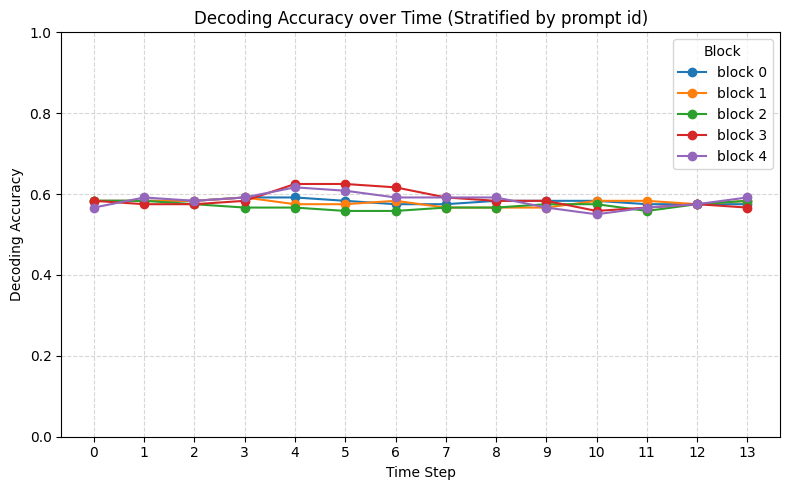

In [59]:
# plot all blocks
plt.figure(figsize=(8,5))
for block_id, accs in results_test.items():
    plt.plot(range(14), accs, marker='o', label=f"block {block_id}")
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy over Time (Stratified by prompt id)')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Block")
plt.tight_layout()
plt.show()

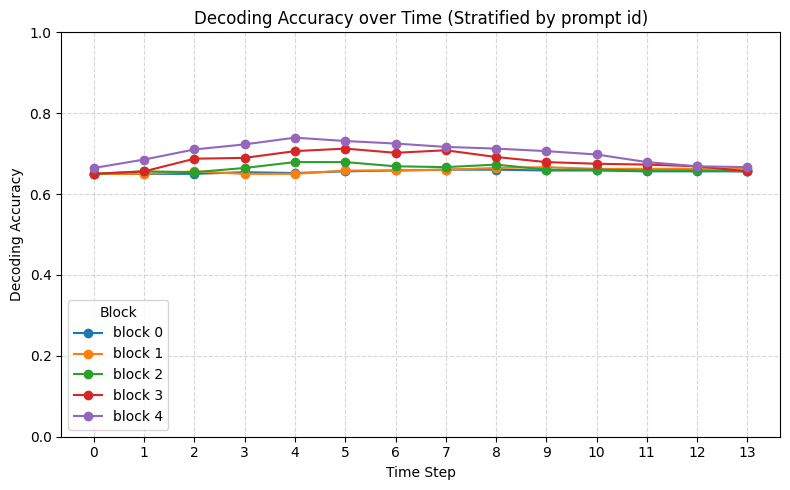

In [60]:
# plot all blocks
plt.figure(figsize=(8,5))
for block_id, accs in results_train.items():
    plt.plot(range(14), accs, marker='o', label=f"block {block_id}")
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy over Time (Stratified by prompt id)')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Block")
plt.tight_layout()
plt.show()

In [50]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import glob
# find all of your “success” files
succ_paths = sorted(glob.glob("classifier_prep_latents/succ_arrays_block_*.pkl"))

results_test = {}  # block_id -> list of 14 accuracies
results_train = {}  # block_id -> list of 14 accuracies

for succ_path in succ_paths:
    # derive the corresponding failure path
    fail_path = succ_path.replace("succ_arrays", "fail_arrays")
    
    # extract a block identifier for labeling
    block_id = succ_path.rstrip(".pkl").split("_")[-1]
    
    # load the dicts
    with open(fail_path, "rb") as f:
        dict_incorrect = pickle.load(f)
    with open(succ_path, "rb") as f:
        dict_correct = pickle.load(f)
    # ————— Run through timesteps ————— #
    accuracies_test = []
    accuracies_train = []
    for t in range(14):
        X, y,f1,f2 = prepare_dataset(dict_correct, dict_incorrect, t)
        X_train, X_test, y_train, y_test = split_unstratified(X, y)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        acc_test = clf.score(X_test, y_test)
        acc_train = clf.score(X_train, y_train)
        accuracies_test.append(acc_test)
        accuracies_train.append(acc_train)
    results_test[block_id] = accuracies_test
    results_train[block_id] = accuracies_train



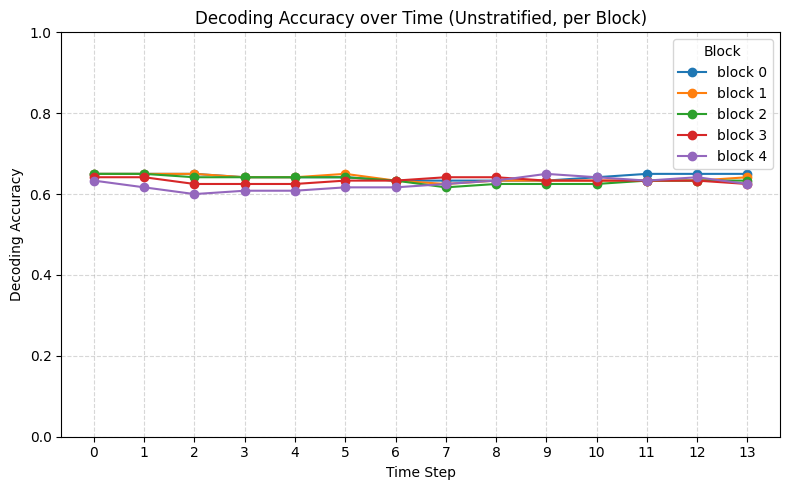

In [51]:
# plot all blocks
plt.figure(figsize=(8,5))
for block_id, accs in results_test.items():
    plt.plot(range(14), accs, marker='o', label=f"block {block_id}")
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy over Time (Unstratified)')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Block")
plt.tight_layout()
plt.show()

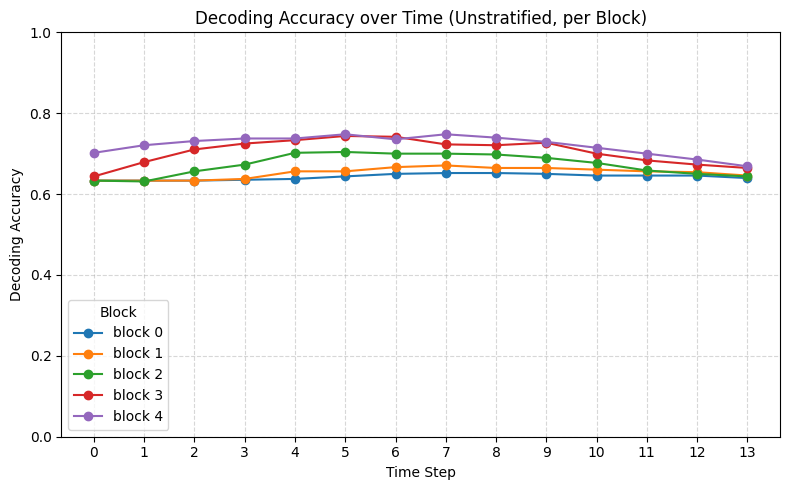

In [52]:
# plot all blocks
plt.figure(figsize=(8,5))
for block_id, accs in results_train.items():
    plt.plot(range(14), accs, marker='o', label=f"block {block_id}")
plt.xlabel('Time Step')
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy over Time (Unstratified)')
plt.xticks(range(14))
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Block")
plt.tight_layout()
plt.show()